In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(1, '../../../../scripts/')
from s3_support import *
%matplotlib inline

# Load transactions data for performance indicator

We load the monthly sums of transaction volume and count for each organization. We are going to drop any organization with fewer than 3 months of non $0 funraising and calculate their average transaction count and volume growth.

In [2]:
trans = redshift_query_read("select count(id) as count, sum(amount) as volume, org, form, date_trunc('month', date) as month from transactions where status='A' group by org, form, date_trunc('month', date)")

In [3]:
trans_agg = []
for form in trans['form'].unique():
    _trans = trans[trans['form']==form].copy()
    _trans = _trans[_trans['volume']>0]
    
    if len(_trans) > 3:
        _trans.sort_values('month', ascending=True, inplace=True)
        _trans['growth_vol'] = _trans['volume'].diff() / _trans['volume'].shift()
        _trans['growth_count'] = _trans['count'].diff() / _trans['count'].shift()

        trans_agg.append({
            'form': form,
            'org': _trans['org'].iloc[0],
            'volume': _trans['growth_vol'].tail(12).mean(),
            'count': _trans['growth_count'].tail(12).mean(),
            'last_12_available': len(_trans.tail(12))
        })

In [4]:
trans_agg = pd.DataFrame(trans_agg)
trans_agg.head()

,count,form,last_12_available,org,volume
0,0.981332,130,12,131,1.010111
1,1.105879,167,12,193,0.628491
2,2.233593,163,12,189,3.479721
3,0.188291,151,6,177,0.182765
4,-0.037500,68,9,94,0.552573


In [5]:
# dropping forms w/ less than 3 months data
less_than_6_months = len(trans_agg[trans_agg['last_12_available']<=6])

print("{} orgs, {} entries".format(len(trans_agg['org'].unique()), len(trans_agg)))
print("{:.2f}% of forms have less than 6 months performance history".format((less_than_6_months / len(trans_agg)) * 100.))
print("{} forms left after dropping those with less than 6 months history".format(len(trans_agg[trans_agg['last_12_available']>6])))

3796 orgs, 10020 entries
34.42% of forms have less than 6 months performance history
6571 forms left after dropping those with less than 6 months history


In [6]:
print("System wide means:")
print("Volume: {:.2f}".format(trans_agg['volume'].replace([np.inf, -np.inf], np.nan).dropna().mean()))
print("Count: {:.2f}".format(trans_agg['count'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

System wide means:
Volume: 41.65
Count: 1.42


# Load log data

In [7]:
df_logs = redshift_query_read("select * from logs")

In [8]:
entry_labels = [
    "has reached their fundraising", "has reached its fundraising", "has earned the %badge",
    "had the %badge", "donated %amount", "made a donation to", "was donated to",
    "A donation was made to", "% registered", "joined %team", "has been registered",
    "reset account password", "switched donation from", "activated recurring", "updated donor information",
    "deleted team", "Raise Your First Donation", "Share on Facebook / Twitter",
    "Upload Your Avatar", "Recruit a Team Member", "Update Your Personal Page",
    "Send a Fundraising Email", "updated organization", "added participant",
    "added payment method", "edited payment method", "deleted payment method",
    "cancelled recurring", "deleted participant", "changed settings for recipient",
    "resent email receipt to email", "updated personal information for transaction",
    "updated donation information for transaction", "updated recurring",
    "updated personal information for recurring", "updated frequency information for recurring",
    "updated payment method for recurring", "updated amount for recurring",
    "updated payment expiration date for recurring", "paused recurring", "updated billing information for recurring",
    "changed end date", "changed start date", "updated registration information for transaction",
    "changed code from", "changed fee from", "voided transaction", "linked transaction",
    "unlinked transaction", "link transaction", "linked recurring", "unlinked recurring",
    "added a return for transaction", "added a chargeback for transaction", "refund",
    "custom report", "set form", "changed form", "changed organization", "resent notification",
    "resent admin notification", "sent password reset email", "edited team", "changed maximum quantity",
    "disabled promo", "switched participant", "switched team", "updated account password",
    "added Form widget", "updated Form widget", "cloned a new form", "edited donor",
    "created Fixed Fee", "updated Fixed Fee", "updated One Time Fee", "created One Time Fee",
    "promoted participant", "added recipient", "sms code", "verified donation",
    "changed username", "merchant account", "signup", "edited participant", 
    "removed participant", "API Access", "status from active"
]


def label_log_entry(msg):
    for i, l in enumerate(entry_labels):
        if l in msg:
            return i
    return None

In [9]:
df_logs['created'] = pd.to_datetime(df_logs['created'])
df_logs['month'] = df_logs['created'].dt.month
df_logs['year'] = df_logs['created'].dt.year
df_logs['monthyear'] = df_logs.apply(lambda x: str(x['year'])+'/'+str(x['month']), axis=1)

df_logs['message_label'] = df_logs['message'].apply(label_log_entry)

In [10]:
cols = ['org', 'form', 'created', 'monthyear', 'message_label']
df_logs = df_logs[cols]
df_logs.head(3)

,org,form,created,monthyear,message_label
0,441530,944710,2019-05-01 21:11:32,2019/5,2.0
1,441530,944710,2019-05-01 21:11:32,2019/5,4.0
2,443692,942649,2019-05-01 21:10:05,2019/5,4.0


# Exploring

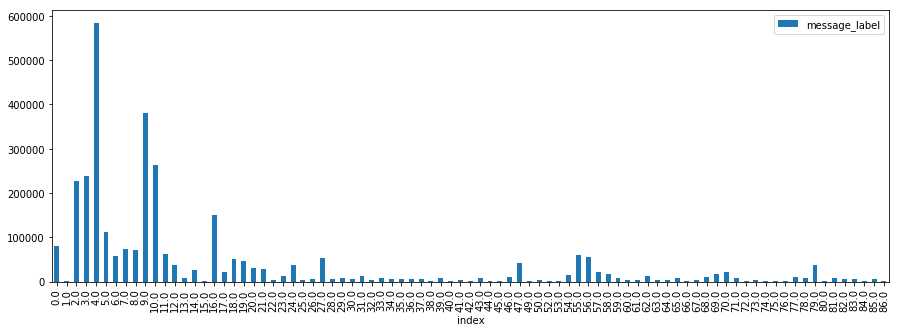

In [11]:
df_logs['message_label'].value_counts().reset_index().sort_values("index").plot(x="index", kind="bar", figsize=(15,5))

In [12]:
grpd = df_logs.groupby('form')['message_label'].value_counts()

grpd = pd.DataFrame(grpd)
grpd.columns = ['count']
grpd = grpd.reset_index().pivot(index="form", values="count", columns="message_label").fillna(0).reset_index()

In [13]:
grpd.head()

message_label,form,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0
0,0,0.0,0.0,0.0,0.0,6.0,0.0,142.0,0.0,0.0,...,170.0,5119.0,0.0,0.0,3540.0,2788.0,0.0,0.0,90.0,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [14]:
mrgd = grpd.merge(trans_agg[['count', 'volume', 'form']], on='form')
mrgd.head()

,form,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,count,volume
0,0,0.0,0.0,0.0,0.0,6.0,0.0,142.0,0.0,0.0,...,0.0,0.0,3540.0,2788.0,0.0,0.0,90.0,1.0,0.000000,-0.140000
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074394,-0.011222
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.620534,0.326930
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.478839,0.566674
4,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,0.0,0.0,13.0,0.0,0.445267,1.604923


In [15]:
# normalize log entry counts
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(mrgd[[c for c in mrgd.columns if c not in ['form', 'count', 'volume']]])
df_norm = pd.DataFrame(x_scaled)
df_norm = df_norm.merge(mrgd[['form', 'count', 'volume']], left_index=True, right_index=True)
df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,form,count,volume
0,0.0,0.0,0.0,0.0,0.000406,0.0,0.158305,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.254237,0.142857,0,0.000000,-0.140000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1,0.074394,-0.011222
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,2,0.620534,0.326930


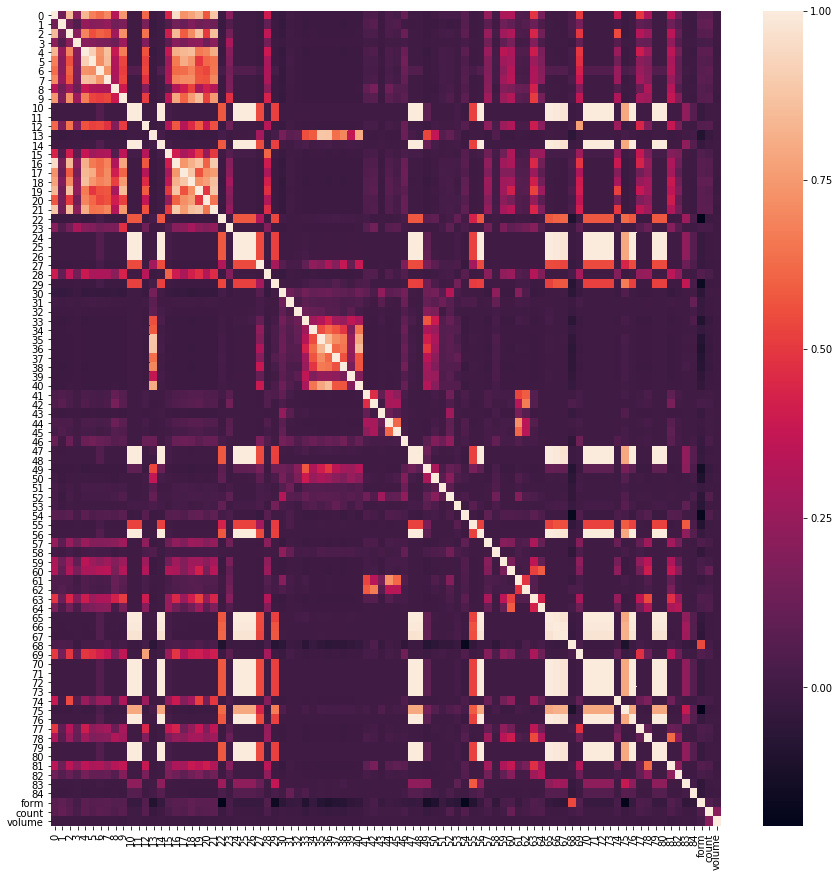

In [16]:
corr = df_norm.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

There appears to be very little correlation between the log entries and transaction growth. This doesn't necessarily mean that they're not predictive. We will still attempt to model them to try to find some predictive value.

# Modeling and examining feature importance

In [17]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import train_test_split

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [39]:
trial_count = 50

## Modeling volume growth

In [41]:
error = []
for i in range(trial_count):
    X_train, X_test, y_train, y_test = train_test_split(df_norm[[c for c in df_norm.columns if c not in ['form', 'count', 'volume']]], df_norm['volume'], test_size=0.25)

    rf = rfr()
    rf.fit(X_train, y_train)
    error.append(rf.score(X_test, y_test))
    
print("Mean error over {} trials: {:.4f}".format(trial_count, np.mean(error)))

Mean error over 50 trials: -0.9704


In [36]:
importances = rf.feature_importances_
pd.DataFrame([{'column': e[1], 'importance': e[0]} for e in list(zip(importances, X_train.columns))]).sort_values('importance', ascending=False).transpose()

,46,32,54,52,30,68,43,31,45,13,...,79,84,80,74,10,71,70,72,48,73
column,46.000000,32.00000,54.000000,52.000000,30.000000,68.000000,43.000000,31.000000,45.000000,13.00000,...,79.000000,84.000000,80.000000,74.000000,10.000000,71.000000,7.000000e+01,7.200000e+01,4.800000e+01,73.0
importance,0.195099,0.11929,0.118758,0.100233,0.080615,0.064406,0.057699,0.056948,0.048907,0.02577,...,0.000004,0.000003,0.000002,0.000002,0.000002,0.000001,1.105109e-07,1.915959e-09,2.725023e-13,0.0


## Modeling count growth

In [42]:
error = []
for i in range(trial_count):
    X_train, X_test, y_train, y_test = train_test_split(df_norm[[c for c in df_norm.columns if c not in ['form', 'count', 'volume']]], df_norm['count'], test_size=0.25)

    rf = rfr()
    rf.fit(X_train, y_train)
    error.append(rf.score(X_test, y_test))

print("Mean error over {} trials: {:.4f}".format(trial_count, np.mean(error)))

Mean error over 50 trials: -0.2621


In [34]:
importances = rf.feature_importances_
pd.DataFrame([{'column': e[1], 'importance': e[0]} for e in list(zip(importances, X_train.columns))]).sort_values('importance', ascending=False).transpose()

,20,54,16,46,52,24,31,50,17,18,...,56,26,80,70,84,25,79,72,73,48
column,20.00000,54.000000,16.000000,46.00000,52.000000,24.00000,31.000000,50.000000,17.000000,18.000000,...,56.000000,26.000000,80.000000,70.000000,84.000000,25.000000,79.000000,7.200000e+01,73.0,48.0
importance,0.12655,0.079043,0.078422,0.06678,0.064814,0.04912,0.041889,0.033717,0.033617,0.029065,...,0.000064,0.000063,0.000042,0.000038,0.000037,0.000031,0.000017,1.980912e-09,0.0,0.0


The growth prediction had a mean error rate of -97% and -26% for volume and count respectively.

It performed quite badly on both volume and count but relative to other models against form performance, and given their general volatility, this is not a dismal performance. It does appear that some columns could yield meaningful importance in modeling after trimming less relevant predictors.

__With feature selection I believe some of this data will prove useful.__